# Basic text classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents
* [Basic text classification with Naive Bayes](#BOW-model-and-Naive-Bayes)
	* [Rotten Tomatoes data set](#Rotten-Tomatoes-data-set)
		* [Explore](#Explore)
	* [The Vector space model and a search engine.](#The-Vector-space-model-and-a-search-engine.)
		* [In Code](#In-Code)
	* [Naive Bayes](#Naive-Bayes)
		* [Cross-Validation and hyper-parameter fitting](#Cross-Validation-and-hyper-parameter-fitting)
		* [Work with the best params](#Work-with-the-best-params)
	* [Interpretation](#Interpretation)
	* [Ideas to improve](#To-improve:)


## Rotten Tomatoes data set

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print "Number of reviews: %i" % n_reviews
print "Number of critics: %i" % n_critics
print "Number of movies:  %i" % n_movies

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


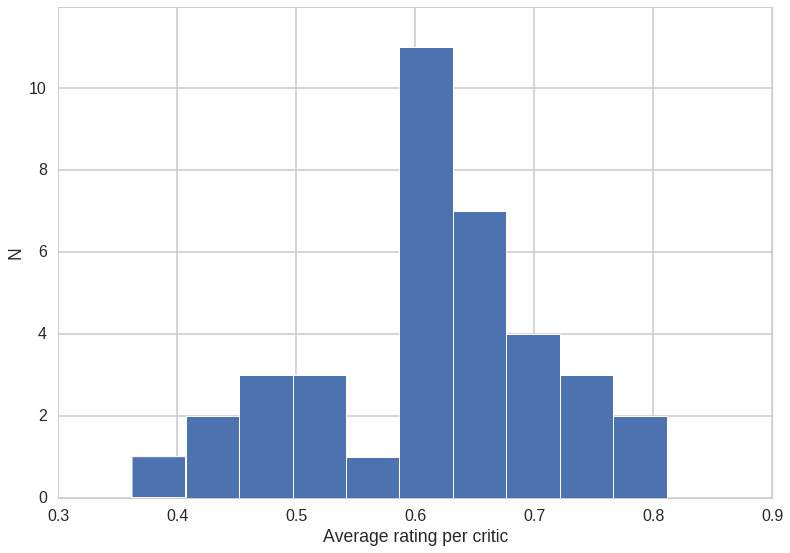

In [4]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average rating per critic")
plt.ylabel("N")
plt.yticks([0, 2, 4, 6, 8, 10]);

## The Vector space model and a search engine.

All the diagrams here are snipped from
See http://nlp.stanford.edu/IR-book/ which is a great resource on Text processing.

Also check out Python packages nltk, spacy, and pattern, and their associated resources.

Let us define the vector derived from document d by $\bar V(d)$. What does this mean? Each document is considered to be a vector made up from a vocabulary, where there is one axis for each term in the vocabulary.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Then the document

"hello world world"

would be indexed as

`[(5,1),(99,2)]`

along with a dictionary

``
5: Hello
99: World
``

so that you can see that our representation is one of a sparse array.

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays and columns "being" the features, ie the vocabulary. I put "being" in quites as the layout in memort is that of a matrix with many 0's, but, rather, we use the sparse representation we talked about above.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, jealous and jealousy after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all deoends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

This we can use this simple Vector Model as a Search engine.

### In Code

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print "Original text is\n", '\n'.join(text)

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print
print "Transformed text vector is \n", x

# `get_feature_names` tracks which word is associated with each column of the transformed x
print
print "Words for each feature:"
print vectorizer.get_feature_names()

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
[u'hop', u'off', u'on', u'pop']


In [8]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)
print X, y

  (1028, 0)	1
  (3215, 0)	1
  (4740, 0)	1
  (4741, 0)	1
  (8722, 0)	2
  (8820, 0)	1
  (12118, 0)	1
  (4031, 1)	1
  (74, 2)	1
  (76, 2)	1
  (3653, 2)	1
  (4031, 2)	1
  (8023, 2)	1
  (10704, 2)	1
  (13425, 2)	1
  (13435, 2)	1
  (13668, 2)	1
  (13693, 2)	1
  (8647, 3)	1
  (369, 4)	1
  (24, 5)	1
  (65, 5)	1
  (472, 5)	1
  (625, 5)	1
  (731, 5)	1
  :	:
  (14548, 22402)	1
  (14551, 22402)	1
  (958, 22403)	1
  (10209, 22403)	1
  (6804, 22404)	1
  (8594, 22405)	1
  (14697, 22406)	1
  (6465, 22407)	1
  (4134, 22408)	1
  (8145, 22408)	1
  (4471, 22409)	1
  (4477, 22409)	1
  (4478, 22409)	1
  (4476, 22410)	1
  (8847, 22411)	1
  (1076, 22412)	1
  (3126, 22412)	1
  (3128, 22412)	1
  (9252, 22412)	1
  (2774, 22413)	1
  (3360, 22414)	1
  (5930, 22414)	1
  (10457, 22414)	1
  (4473, 22415)	1
  (8518, 22416)	1 [1 1 1 ..., 1 1 1]


## Naive Bayes

$$P(c|d) \propto P(d|c) P(c) $$

$$P(d|c)  = \prod_k P(t_k | c) $$

the conditional independence assumption.

Then we see that for which c is $P(c|d)$ higher.

For floating point underflow we change the product into a sum by going into log space. So:

$$log(P(d|c))  = \sum_k log (P(t_k | c)) $$

But we must also handle non-existent terms, we cant have 0's for them:

$$P(t_k|c) = \frac{N_{kc}+\alpha}{N_c+\alpha N_{feat}}$$

**Your turn:** Implement a simple Naive Bayes classifier

* Use `scikit-learn`'s `MultinomialNB()`  classifier with default parameters.
* split the data set into a training and test set
* train the classifier over the training set and test on the test set
* print the accuracy scores for both the training and the test sets

What do you notice? Is this a good classifier? If not, why not?

In [13]:
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB


xtrain, xtest, ytrain, ytest = train_test_split(X, y)
clf = MultinomialNB().fit(xtrain, ytrain)
score = clf.score(xtest, ytest)
print score * 100

clf.score(xtrain, ytrain) * 100

76.5098946286


92.553556126820908

### Cross-Validation and hyper-parameter fitting

We use `KFold` instead of `GridSearchCV` here as we will want to also set parameters in the CountVectorizer.

In [36]:
from sklearn.cross_validation import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

Since Naive Bayes classifiers are often used in asymmetric situations, it might help to actually maximize probability on the validation folds rather than just accuracy.

Notice something else about using a custom score function. It allows us to do a lot of the choices with the Decision risk we care about (-profit for example) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as risks or scores.

In [37]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

**Your turn:** What is using this function as the score mean? What are we trying to optimize for?

We'll cross-validate over the regularization parameter $\alpha$ and the `min_df` of the `CountVectorizer`.

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

Lets set up the train and test masks first:

In [38]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(critics.shape[0]), train_size=0.7)
mask=np.ones(critics.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

**Your turn:** 
    
Using the skeleton code below, find the best values of the parameters `alpha` and `min_df`. 
Use the `cv_score` function above with the `log_likelihood` function for scoring.

In [42]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf

for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        clf = MultinomialNB(alpha=alpha)
        s = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
        if s > maxscore:
            maxscore = s
            best_alpha = alpha
            best_min_df = min_df

In [43]:
print "alpha: %f" % best_alpha
print "min_df: %f" % best_min_df

alpha: 5.000000
min_df: 0.001000


### Work with the best params

**Your turn: **  Using the best values of  `alpha` and `min_df` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?

In [44]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

Accuracy on training data: 0.79
Accuracy on test data:     0.74


In [45]:
from sklearn.metrics import confusion_matrix
print confusion_matrix(ytest, clf.predict(xtest))

[[1103  733]
 [ 483 2350]]


## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [46]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print "Good words\t     P(fresh | word)"
for w, p in zip(good_words, good_prob):
    print "%20s" % w, "%0.2f" % (1 - np.exp(p))
    
print "Bad words\t     P(fresh | word)"
for w, p in zip(bad_words, bad_prob):
    print "%20s" % w, "%0.2f" % (1 - np.exp(p))

Good words	     P(fresh | word)
              superb 0.89
             delight 0.88
        entertaining 0.87
         masterpiece 0.87
            touching 0.87
                rare 0.86
               witty 0.86
             kubrick 0.86
          remarkable 0.86
            powerful 0.84
Bad words	     P(fresh | word)
               fails 0.21
           pointless 0.20
      disappointment 0.20
             unfunny 0.20
               bland 0.19
          uninspired 0.18
             problem 0.17
                dull 0.17
       unfortunately 0.16
                lame 0.15


**Your turn:** Why does this method work? What does the probability for each row in the identity matrix represent?

>The probability for each row represents the how strongly our classifier assosiates said word with either the positive or negative class. In other words, it represents the word's predictive power in our classifier.
The words with highest predictive power for the positive class, such as 'superb', 'delight' would have the highest probability of prediction. Likewise, words such as 'lame', have the lowest probabilities.

### Mis-predictions

We can see mis-predictions as well.

In [69]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print "Mis-predicted Rotten quotes"
print '---------------------------'
for row in bad_rotten:
    print critics[y == 0].quote.irow(row)
    print

print "Mis-predicted Fresh quotes"
print '--------------------------'
for row in bad_fresh:
    print critics[y == 1].quote.irow(row)
    print

Mis-predicted Rotten quotes
---------------------------
It's a sad day when an actor who's totally, beautifully in touch with his dark side finds himself stuck in a movie that's scared of its own shadow.

Benefits from a lively lead performance by the miscast Denzel Washington but doesn't come within light years of the book, one of the greatest American autobiographies.

The hip, smart yarn has a bite not seen in American movies since The War of the Roses.

Directed with composure, but no great fervour, the film's conspicuously uninterested in American football, and much concerned with testing the limits and the resilience of the American dream.

Nava, who started his feature-film career with El Norte, is a good director who invariably finds a strong rapport with his actors. He's not much of a writer, though, and he should think twice about creating dialogue for his future projects.

Mis-predicted Fresh quotes
--------------------------
The gangland plot is flimsy (bad guy Peter Greene

/home/indrajit/.virtualenvs/work/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: irow(i) is deprecated. Please use .iloc[i] or .iat[i]
/home/indrajit/.virtualenvs/work/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: irow(i) is deprecated. Please use .iloc[i] or .iat[i]


### Predicting the freshness for a new review

**Your turn:**

* Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
* Is the result what you'd expect? Why (not)?

In [76]:
# Best Classifier
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
# print X.shape
# print y.shape
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)
txt = vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])
# print txt.shape
print clf.predict(txt)

[1]


Our prediction for the review *This movie is not remarkable, touching, or superb in any way* is wrong. This might be because of our reliance on the bag of words technique, which loses the order and semantics of the sentence. The sentence in question uses positive words such as remarkable, touching and superb, but the *not* in front of it changes the connotation. Our model does not account for such changes since it looks at words in isolation

## Fun things to try and improve this model:

There are many things worth trying. Some examples:

- You could try to build a NB model where the features are word pairs instead of words. This would be smart enough to realize that "not good" and "so good" mean very different things. This technique doesn't scale very well, since these features are much more sparse (and hence harder to detect repeatable patterns within).
- You could try a model besides NB, that would allow for interactions between words -- for example, a Random Forest classifier.
- You could consider adding supplemental features -- information about genre, director, cast, etc.
- You could build a visualization that prints word reviews, and visually encodes each word with size or color to indicate how that word contributes to P(Fresh). For example, really bad words could show up as big and red, good words as big and green, common words as small and grey, etc.

### Better features

We could use TF-IDF instead. What is this? It stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weigh this term frequency by the inverse of its popularity in all document. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. By weighing its counts by 1 divides by its overall frequency, we down-weight it. We can then use this tfidf weighted features as inputs to any classifier.

In [151]:
#http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
#http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)
ytfidf = (critics.fresh == 'fresh').values.astype(np.int)
print Xtfidf.shape

txt = tfidfvectorizer.transform(['This movie is not remarkable, touching, or superb in any way', ])
txt2 = tfidfvectorizer.transform(['Superb', ])

(15561, 22126)


**Your turn (extra credit):** Try a few of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result.

In [152]:
xtrain, xtest, ytrain, ytest = train_test_split(Xtfidf, ytfidf)
clf = MultinomialNB()
clf.fit(xtrain, ytrain)
print xtrain.shape

print clf.score(xtest, ytest)
print clf.score(xtrain, ytrain)
print clf.predict(txt)

(11670, 22126)
0.711642251349
0.848157669237
[1]


In [213]:
# Use pairs of words as features
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

stops = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

def generate_pairs(sentence):
    tokens = tokenizer.tokenize(sentence)
    return ' ' + ' '.join([x[0] + x[1] for x in zip(tokens, tokens[1:]) if not(x[0] in stops and x[1] in stops)])

def make_X(sentences):
    data = [(sentence, generate_pairs(sentence), sentence + generate_pairs(sentence)) for sentence in sentences]
    return pd.DataFrame(data, columns=['quote', 'quote_extend', 'quote_both'])

In [214]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
critics['quote_extend'] = critics.quote.apply(generate_pairs)
critics['quote_both'] = critics.quote + critics.quote_extend

In [219]:
x = make_X(['This movie is not remarkable, touching, or superb in any way', ])
print x.head()

                                               quote                                       quote_extend                                         quote_both
0  This movie is not remarkable, touching, or sup...   Thismovie movieis notremarkable remarkabletou...  This movie is not remarkable, touching, or sup...


In [223]:
Xtfidf = tfidfvectorizer.fit_transform(critics.quote_both)
new_x = tfidfvectorizer.transform(x.quote_both)
ytfidf = (critics.fresh == 'fresh').values.astype(np.int)
xtrain, xtest, ytrain, ytest = train_test_split(Xtfidf, ytfidf)
clf = MultinomialNB()
clf.fit(xtrain, ytrain)

print clf.score(xtest, ytest)
print clf.score(xtrain, ytrain)
print clf.predict(new_x)
print x.quote

0.665638653302
0.91028277635
[1]
0    This movie is not remarkable, touching, or sup...
Name: quote, dtype: object


In [224]:
Xtfidf = tfidfvectorizer.fit_transform(critics.quote)
new_x = tfidfvectorizer.transform(x.quote)
ytfidf = (critics.fresh == 'fresh').values.astype(np.int)
xtrain, xtest, ytrain, ytest = train_test_split(Xtfidf, ytfidf)
clf = MultinomialNB()
clf.fit(xtrain, ytrain)

print clf.score(xtest, ytest)
print clf.score(xtrain, ytrain)
print clf.predict(new_x)
print x.quote

0.712413261372
0.837703513282
[1]
0    This movie is not remarkable, touching, or sup...
Name: quote, dtype: object


In [225]:
Xtfidf = tfidfvectorizer.fit_transform(critics.quote_extend)
new_x = tfidfvectorizer.transform(x.quote_extend)
ytfidf = (critics.fresh == 'fresh').values.astype(np.int)
xtrain, xtest, ytrain, ytest = train_test_split(Xtfidf, ytfidf)
clf = MultinomialNB()
clf.fit(xtrain, ytrain)

print clf.score(xtest, ytest)
print clf.score(xtrain, ytrain)
print clf.predict(new_x)
print x.quote

0.658956566435
0.972322193659
[1]
0    This movie is not remarkable, touching, or sup...
Name: quote, dtype: object
